In [ ]:
!pip install pyspark
!pip install graphframes
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("LinkedIn Job Postings").master("local[*]").config("spark.jars.packages", "graphframes:graphframes:0.8.1-spark3.0-s_2.12").getOrCreate()
from pyspark.ml.feature import Imputer

In [ ]:
file_paths = {
    "benefits": "benefits.csv",
    "companies": "companies.csv",
    "company_industries": "company_industries.csv",
    "company_specialities": "company_specialities.csv",
    "employee_counts": "employee_counts.csv",
    "industries": "industries.csv",
    "job_industries": "job_industries.csv",
    "job_postings": "job_postings.csv",
    "job_skills": "job_skills.csv",
    "salaries": "salaries.csv",
    "skills": "skills.csv",
}

In [ ]:
# Assuming simplified schema for demonstration, adjust according to your CSV files
job_postings_schema = "job_id STRING, title STRING, description STRING, location STRING, company_id STRING"
job_industries_schema = "job_id STRING, industry_id STRING"
job_skills_schema = "job_id STRING, skill_abr STRING"
industries_schema = "industry_id STRING, industry_name STRING"
skills_schema = "skill_abr STRING, skill_name STRING"
salaries_schema = "job_id STRING, salary INT, currency STRING"
employee_counts_schema = "company_id STRING, employee_count INT"

# Read CSV files into DataFrames, assuming header=True and inferring schema for demonstration
job_postings_df = spark.read.option("header", "true").csv("job_postings.csv", inferSchema=True)
job_industries_df = spark.read.option("header", "true").csv("job_industries.csv", inferSchema=True)
job_skills_df = spark.read.option("header", "true").csv("job_skills.csv", inferSchema=True)
industries_df = spark.read.option("header", "true").csv("industries.csv", inferSchema=True)
skills_df = spark.read.option("header", "true").csv("skills.csv", inferSchema=True)

# Perform joins
joined_df = job_postings_df \
    .join(job_industries_df, "job_id") \
    .join(industries_df, "industry_id") \
    .join(job_skills_df, "job_id") \
    .join(skills_df, "skill_abr")

In [ ]:
import shutil
import time

streaming_directory = "stream_simulation/"
streaming_checkpoint_directory = "stream_checkpoint/"

# Convert the DataFrame to JSON and save it to simulate the initial load
joined_df.write.mode("overwrite").json(streaming_directory)

# Assuming the schema of joined_df is correctly defined and does not include duplicate columns
stream_df = spark.readStream.schema(joined_df.schema).json(streaming_directory)

# Start the streaming query to output to a memory table
query = stream_df.writeStream.queryName("streaming_data").format("memory").outputMode("update").start()

# Function to perform SQL queries and display results
def display_streaming_data():
    # Display top industries by job postings
    print("Job Postings by Industry:\n")
    spark.sql("""
        SELECT industry_name, COUNT(*) AS job_count
        FROM streaming_data
        GROUP BY industry_name
        ORDER BY job_count DESC
    """).show(truncate=False)

    # Display top skills by job postings
    print("Job Availability by Skill Type:\n")
    spark.sql("""
        SELECT skill_name, COUNT(*) AS job_count
        FROM streaming_data
        GROUP BY skill_name
        ORDER BY job_count DESC
    """).show(truncate=False)

    # Select skill names along with the list of industries that require them
    print("List of Industries by Skills Required:\n")
    spark.sql("""
        SELECT job_skills.skill_name, collect_list(distinct job_industries.industry_name) FROM job_skills JOIN job_industries
        ON job_skills.job_id = job_industries.job_id
        GROUP BY
          job_skills.skill_name
    """).show(truncate=False)

# Simulate streaming by appending new data
for i in range(1, 16):
    print(f"Iteration: {i}")
    # Specify the source file for the initial data
    source_file = streaming_directory + "part-00000"  # This assumes only one part file exists; adjust as necessary
    destination_file = streaming_directory + f"data_{i}.json"

    time.sleep(5)  # Adjust based on your system
    display_streaming_data()

# Stop the query
query.stop()

Iteration: 1
Job Postings by Industry:

+-------------+---------+
|industry_name|job_count|
+-------------+---------+
+-------------+---------+

Job Availability by Skill Type:

+----------+---------+
|skill_name|job_count|
+----------+---------+
+----------+---------+

Iteration: 2
Job Postings by Industry:

+-----------------------------------------------------+---------+
|industry_name                                        |job_count|
+-----------------------------------------------------+---------+
|IT Services and IT Consulting                        |6036     |
|Hospitals and Health Care                            |4672     |
|Staffing and Recruiting                              |3988     |
|Retail                                               |3571     |
|Financial Services                                   |3501     |
|Software Development                                 |3123     |
|Construction                                         |2035     |
|Technology, Information and 

In [ ]:
for name, path in file_paths.items():
    df = spark.read.csv(path, header=True, inferSchema=True)
    rdd = df.rdd
    columns = df.columns  # Extract column names
    count = rdd.count()  # Get the number of observations in the RDD

    # Print dataset name, number of observations, and columns
    print(f"Dataset Name: {name}")
    print(f"Number of Observations: {count}")
    print("Columns:", columns)

    # For each column, print the schema description (data type)
    # Since RDDs do not have schema, we extract schema from DataFrame
    for field in df.schema.fields:
        print(f"{field.name}: {field.dataType.simpleString()}")

    print("--------------------------------------------------")

Dataset Name: benefits
Number of Observations: 29325
Columns: ['job_id', 'inferred', 'type']
job_id: bigint
inferred: int
type: string
--------------------------------------------------
Dataset Name: companies
Number of Observations: 44528
Columns: ['company_id', 'name', 'description', 'company_size', 'state', 'country', 'city', 'zip_code', 'address', 'url']
company_id: string
name: string
description: string
company_size: string
state: string
country: string
city: string
zip_code: string
address: string
url: string
--------------------------------------------------
Dataset Name: company_industries
Number of Observations: 12601
Columns: ['company_id', 'industry']
company_id: int
industry: string
--------------------------------------------------
Dataset Name: company_specialities
Number of Observations: 78405
Columns: ['company_id', 'speciality']
company_id: int
speciality: string
--------------------------------------------------
Dataset Name: employee_counts
Number of Observations: 1

In [ ]:
from pyspark.sql.functions import *

# Assuming job_postings_df is already defined as per your schema
job_postings_df = spark.read.csv("job_postings.csv", header=True, schema=job_postings_schema)

# Utilize DataFrame API to count nulls directly without converting to RDD
null_counts = job_postings_df.select([count(when(col(c).isNull(), c)).alias(c) for c in job_postings_df.columns])

print("Count of Null Values in Each Field:")
null_counts.show()

Count of Null Values in Each Field:
+------+------+-----------+--------+----------+
|job_id| title|description|location|company_id|
+------+------+-----------+--------+----------+
|    43|220866|     266169|  295594|    353986|
+------+------+-----------+--------+----------+



In [ ]:
# Assuming you're back to static DataFrames for RDD operations
# Let's take job_postings_df as an example
job_postings_df = spark.read.csv("job_postings.csv", schema=job_postings_schema, header=True)

# Convert to RDD for manipulation
job_postings_rdd = job_postings_df.rdd

# Column descriptions
print("Column Descriptions:")
print(job_postings_df.dtypes)

# Initial few rows
print("Initial Rows:")
for row in job_postings_rdd.take(5):
    print(row)

print("--------------------------------------------------")

Column Descriptions:
[('job_id', 'string'), ('title', 'string'), ('description', 'string'), ('location', 'string'), ('company_id', 'string')]
Initial Rows:
Row(job_id='3757940104', title='553718', description='Hearing Care Provider', location='Overview', company_id=None)
Row(job_id='HearingLife is a national hearing care company and part of the Demant Group', title=' a global leader in hearing healthcare built on a heritage of care', description=' health', location=' and innovation since 1904. HearingLife operates more than 600 hearing care centers across 42 states. We follow a scientific', company_id=' results-oriented approach to hearing healthcare that is provided by highly skilled and caring professionals. Our vision is to help more people hear better through life-changing hearing health delivered by the best personalized care. This Team Member must uphold the HearingLife Core Values:')
Row(job_id=' We create trust  We are team players  We apply a can-do attitude  We create innovat

In [ ]:
structured_conditions = """
For companies in the same city:
- "Rivals": Both have a size >= 5.
- "Partners": One has a size >= 5 and the other has a size between 3 and 5.
- "Unrelated": One has a size >= 5 and the other has a size < 3.
- "Mergers": Both have a size < 5 but >= 3.
- "Allies": One has a size >= 3 but < 5, and the other has a size < 3.
- "Sisters": Both have a size < 3.

For companies in different cities:
- "Allies": If only one has a size >= 4.
- "Partners": If both have a size >= 4.
- "Sisters": If both have a size <= 3.
- "Rivals": For all other conditions.
"""

# Output the structured conditions
print(structured_conditions)


For companies in the same city:
- "Rivals": Both have a size >= 5.
- "Partners": One has a size >= 5 and the other has a size between 3 and 5.
- "Unrelated": One has a size >= 5 and the other has a size < 3.
- "Mergers": Both have a size < 5 but >= 3.
- "Allies": One has a size >= 3 but < 5, and the other has a size < 3.
- "Sisters": Both have a size < 3.

For companies in different cities:
- "Allies": If only one has a size >= 4.
- "Partners": If both have a size >= 4.
- "Sisters": If both have a size <= 3.
- "Rivals": For all other conditions.



In [ ]:
nodes_df = spark.read.csv("Nodes.csv", header=True, inferSchema=True)

# Self-join the DataFrame to create all possible pairs of companies
edges_df = nodes_df.alias("src").join(nodes_df.alias("dst"), col("src.city") == col("dst.city"), "inner") \
    .select(
        col("src.id").alias("src"),
        col("dst.id").alias("dst"),
        when(
            (col("src.size") >= 5) & (col("dst.size") >= 5), "rivals"
        ).when(
            (col("src.size") >= 5) & (col("dst.size") < 5) & (col("dst.size") >= 3), "partners"
        ).when(
            (col("src.size") >= 5) & (col("dst.size") < 3), "unrelated"
        ).when(
            (col("src.size") < 5) & (col("src.size") >= 3) & (col("dst.size") < 5) & (col("dst.size") >= 3), "mergers"
        ).when(
            (col("src.size") >= 3) & (col("src.size") < 5) & (col("dst.size") < 3), "allies"
        ).when(
            (col("src.size") < 3) & (col("dst.size") < 3), "sisters"
        ).otherwise("rivals").alias("relation")
    )

# Filter out duplicate pairs and self-relationships
edges_df = edges_df.filter("src != dst").distinct()

# Display the edges DataFrame
edges_df.show(truncate=False)

# For different cities, we have to create additional rules and append to the current edges DataFrame
different_city_edges_df = nodes_df.alias("src").join(nodes_df.alias("dst"), col("src.city") != col("dst.city"), "inner") \
    .select(
        col("src.id").alias("src"),
        col("dst.id").alias("dst"),
        when(
            (col("src.size") >= 4) & (col("dst.size") >= 4), "partners"
        ).when(
            (col("src.size") <= 3) & (col("dst.size") <= 3), "sisters"
        ).otherwise("rivals").alias("relation")
    )

# Filter out duplicate pairs and self-relationships
different_city_edges_df = different_city_edges_df.filter("src != dst").distinct()

# Union the two datasets
final_edges_df = edges_df.union(different_city_edges_df).distinct()

# Write the edges DataFrame to a CSV file
final_edges_df.write.csv("Edges.csv", header=True, mode="overwrite")

+----+--------+---------+
|src |dst     |relation |
+----+--------+---------+
|1016|1069195 |unrelated|
|1016|15549   |rivals   |
|1016|2432    |rivals   |
|1044|74351350|rivals   |
|1044|18347825|rivals   |
|1044|10112277|unrelated|
|1044|9485258 |unrelated|
|1044|70329   |unrelated|
|1044|9351    |rivals   |
|1052|65616790|unrelated|
|1063|2746392 |partners |
|1068|18358181|unrelated|
|1068|57322   |partners |
|1123|2365947 |unrelated|
|1185|12663962|unrelated|
|1185|11065927|unrelated|
|1185|13550   |rivals   |
|1235|18581793|unrelated|
|1235|3252148 |partners |
|1235|2738186 |partners |
+----+--------+---------+
only showing top 20 rows



In [ ]:
import networkx as nx
from graphframes import GraphFrame
import matplotlib.pyplot as plt

vertices = spark.read.option('header', 'true').csv('Nodes.csv')
edges = spark.read.option('header', 'true').csv('Edges.csv')

vertices.show(5)
edges.show(5)

mygraph = GraphFrame(vertices, edges)

mygraph.vertices.show()
mygraph.edges.show()

# result = mygraph.filterEdges("relationship = 'requires_skill'").filterVertices("size = 7")
# result.vertices.show()
# result.edges.show()

def plot_undirected_graph(edge_list):
    plt.figure(figsize=(9, 9))
    gplot = nx.Graph()
    for row in edge_list.select("src", "dst").take(100):
        gplot.add_edge(row["src"], row["dst"])
    nx.draw(gplot, with_labels=True, font_weight="bold", node_size=500)
    plt.show()

+----+--------------------+----+----------------+--------------+
|  id|                name|size|            city|employee_count|
+----+--------------------+----+----------------+--------------+
|1009|                 IBM|   7|Armonk, New York|        316130|
|1016|       GE HealthCare|   7|         Chicago|         53495|
|1021|            GE Power|   7|     Schenectady|         26963|
|1025|Hewlett Packard E...|   7|         Houston|         70995|
|1028|              Oracle|   7|          Austin|        202019|
+----+--------------------+----+----------------+--------------+
only showing top 5 rows

+----+---------+---------+
| src|      dst| relation|
+----+---------+---------+
|1016| 76439142| partners|
|1025|  8986045|unrelated|
|1025|  3602072| partners|
|1044|100763188|   rivals|
|1052| 33203846|   rivals|
+----+---------+---------+
only showing top 5 rows



/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+----+--------------------+----+----------------+--------------+
|  id|                name|size|            city|employee_count|
+----+--------------------+----+----------------+--------------+
|1009|                 IBM|   7|Armonk, New York|        316130|
|1016|       GE HealthCare|   7|         Chicago|         53495|
|1021|            GE Power|   7|     Schenectady|         26963|
|1025|Hewlett Packard E...|   7|         Houston|         70995|
|1028|              Oracle|   7|          Austin|        202019|
|1033|           Accenture|   7|        Dublin 2|        542886|
|1038|            Deloitte|   7|       Worldwide|        437314|
|1043|             Siemens|   7|          Munich|        213470|
|1044|                 PwC|   7|               0|        273293|
|1052|                AT&T|   7|          Dallas|        169695|
|1060|            Ericsson|   7|           Kista|        111798|
|1063|               Cisco|   7|        San Jose|         99677|
|1068|JPMorgan Chase & Co

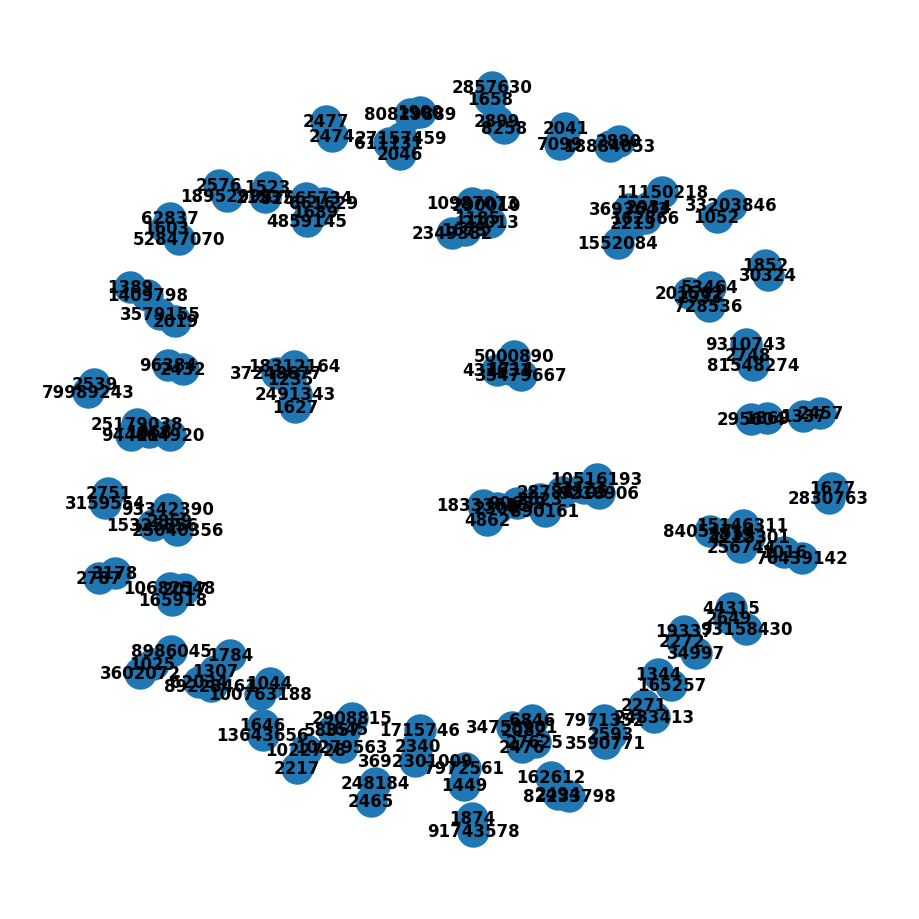

In [ ]:
plot_undirected_graph(mygraph.edges)

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

job_postings_df = spark.read.csv("job_postings.csv", header=True, inferSchema=True)
salaries_df = spark.read.csv("salaries.csv", header=True, inferSchema=True)

data_df = job_postings_df.join(salaries_df, "job_id")

In [ ]:
feature_cols = job_postings_df.columns  # Replace with actual feature columns
feature_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Prepare the data with features and label
data_df = feature_assembler.transform(data_df).select(col("salary").alias("label"), "features")

# Split the data into training and test sets
train_df, test_df = data_df.randomSplit([0.7, 0.3])

In [ ]:
# Initialize models
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

# Train the models
lr_model = lr.fit(train_df)
dt_model = dt.fit(train_df)
rf_model = rf.fit(train_df)

# Make predictions
lr_predictions = lr_model.transform(test_df)
dt_predictions = dt_model.transform(test_df)
rf_predictions = rf_model.transform(test_df)

# Evaluate the models
evaluator = RegressionEvaluator()

lr_rmse = evaluator.evaluate(lr_predictions)
dt_rmse = evaluator.evaluate(dt_predictions)
rf_rmse = evaluator.evaluate(rf_predictions)

# Print RMSE values
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Decision Tree RMSE: {dt_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")

# Determine the best model based on RMSE
best_model = min([(lr_model, lr_rmse), (dt_model, dt_rmse), (rf_model, rf_rmse)], key=lambda x: x[1])
print(f"The best model is: {best_model[0].__class__.__name__} with a RMSE of: {best_model[1]}")